In [9]:
import os

from keras_preprocessing.image import ImageDataGenerator

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from ml.eval import eval_model
from ml.pipeline import FeitDataPipeline
from tensorflow import keras

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import concatenate

from cfg import *

from livelossplot import PlotLossesKerasTF

print(os.getcwd())
os.chdir('/home/jelinek/recetox/')

name = "MySimpleCNN_Inception_module-v2-reduced-11_classes"


/home/jelinek/recetox


In [10]:
class MySimpleCNNInceptionModule(FeitDataPipeline):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.model = self.get_compiled_model()
        self.params.name = name
        self.params.epochs = 200
        self.batch_size = 16
        self.params.tile_size=256

    @staticmethod
    def get_inception_module_dim_reduction(prev_layer, filters_1, filters_2):
        c11 = keras.layers.Conv2D(filters=filters_1, kernel_size=(1,1), padding='same')(prev_layer)
        c12 = keras.layers.Conv2D(filters=filters_2, kernel_size=(1,1), padding='same')(prev_layer)
        c13 = keras.layers.Conv2D(filters=filters_1, kernel_size=(1,1), padding='same')(prev_layer)
        p1 = keras.layers.MaxPooling2D(padding='same', strides=(1,1), pool_size=(3,3))(prev_layer)

        c21 = keras.layers.Conv2D(filters=filters_2, kernel_size=(3,3), padding='same')(c12)
        c22 = keras.layers.Conv2D(filters=filters_2, kernel_size=(5,5), padding='same')(c13)
        c23 = keras.layers.Conv2D(filters=filters_2, kernel_size=(1,1), padding='same')(p1)

        output_layer = concatenate([c11, c21, c22, c23], axis=-1)

        return output_layer


    @staticmethod
    def get_compiled_model():
        inputs = keras.Input(shape=(256, 256, 3))

        x = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(inputs,
                                                filters_1=4,
                                                filters_2=4)

        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(x,
                                                filters_1=8,
                                                filters_2=8)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)


        x = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(x,
                                                filters_1=16,
                                                filters_2=16)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(x,
                                                filters_1=32,
                                                filters_2=32)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(x,
                                                filters_1=64,
                                                filters_2=64)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)


        x = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(x,
                                                filters_1=128,
                                                filters_2=128)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Flatten()(x)
        outputs = keras.layers.Dense(units=11, activation='softmax')(x)

        model = keras.Model(inputs, outputs, name='MySimpleCnnFewerLayers')
        model.summary()
        return model

    def get_data_loader_training(self):
        datagen_train = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, samplewise_center=True,
                                           samplewise_std_normalization=True)

        return datagen_train.flow_from_directory(directory=self.params.data_training, color_mode='rgb',
                                                 class_mode='categorical', batch_size=self.params.batch_size,
                                                 shuffle=True,
                                                 target_size=(self.params.tile_size, self.params.tile_size))

    def get_data_loader_validation(self):
        datagen_valid = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)
        return datagen_valid.flow_from_directory(directory=self.params.data_validation, color_mode='rgb',
                                                 class_mode='categorical', batch_size=self.params.batch_size,
                                                 shuffle=False,
                                                 target_size=(self.params.tile_size, self.params.tile_size))


    def _train_model(self, data_train, data_valid):

        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                      patience=30, min_lr=1e-4, verbose=1,
                                      cooldown=20)

        self.model.fit(data_train,
                       steps_per_epoch=250,
                       epochs=200,
                       shuffle=True,
                       validation_data=data_valid,
                       validation_freq=10,
                       verbose=1,
                       callbacks=[self.tensorboard, reduce_lr, PlotLossesKerasTF()])

In [11]:
pipeline = MySimpleCNNInceptionModule(train_data_dir='data/Feit_colon-annotation-tiles-256/data_train/',
                        valid_data_dir='data/Feit_colon-annotation-tiles-256/data_valid/')

Model: "MySimpleCnnFewerLayers"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_73 (Conv2D)             (None, 256, 256, 4)  16          ['input_3[0][0]']                
                                                                                                  
 conv2d_74 (Conv2D)             (None, 256, 256, 4)  16          ['input_3[0][0]']                
                                                                                                  
 max_pooling2d_24 (MaxPooling2D  (None, 256, 256, 3)  0          ['input_3[0]

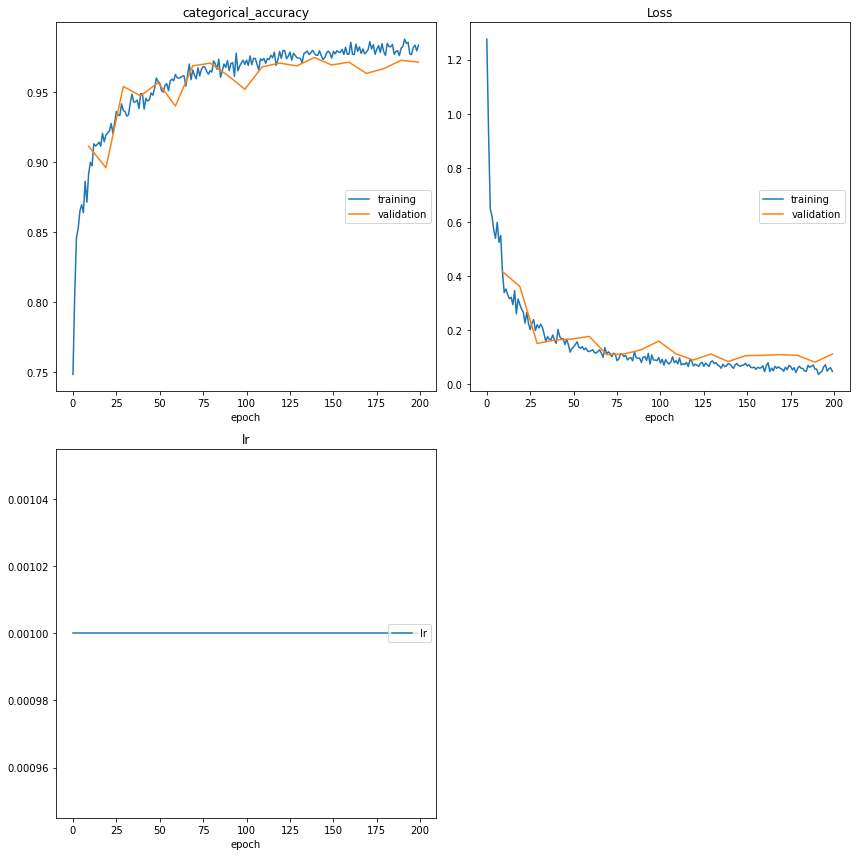

categorical_accuracy
	training         	 (min:    0.748, max:    0.988, cur:    0.984)
	validation       	 (min:    0.896, max:    0.975, cur:    0.971)
Loss
	training         	 (min:    0.037, max:    1.276, cur:    0.048)
	validation       	 (min:    0.082, max:    0.417, cur:    0.112)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
250/250 [==============================] - 20s 79ms/step - loss: 0.0477 - categorical_accuracy: 0.9835 - val_loss: 0.1120 - val_categorical_accuracy: 0.9713 - lr: 0.0010
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 0.7436ms
Confusion Matrix
[[329   0   1   0   1   0   0   0   0   0   4]
 [  2  43   9   1   0   0   4   4   1   0   0]
 [  0   2 141   0   2   0   0   0   0   0   0]
 [  0   0   0  11   0   0   0   0   0   0   0]
 [  0   0   0   2 542   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0]
 [  0   1   1   0   0   0  75   0   0   0   0]
 [  0   0   1   0   0   0   1  84   0   0   0]
 [

In [12]:
pipeline.execute_pipeline(perform_validation=True, perform_test_segmentation=False)

In [13]:
pipeline.save_pipeline()

In [14]:
eval_model(pipeline.model,
           pipeline.get_data_loader_validation(),
           pipeline_name=name,
           print_confusion_matrix=True,
           save_misclassified=True)

Found 1499 images belonging to 11 classes.
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 0.6985ms
Confusion Matrix
[[329   0   1   0   1   0   0   0   0   0   4]
 [  2  43   9   1   0   0   4   4   1   0   0]
 [  0   2 141   0   2   0   0   0   0   0   0]
 [  0   0   0  11   0   0   0   0   0   0   0]
 [  0   0   0   2 542   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0]
 [  0   1   1   0   0   0  75   0   0   0   0]
 [  0   0   1   0   0   0   1  84   0   0   0]
 [  0   0   0   0   0   0   0   0   1   0   0]
 [  0   0   1   0   0   0   0   0   0   0   0]
 [  5   0   0   0   0   0   0   0   0   0 229]]
Classification Report
                             precision    recall  f1-score   support

             adenocarcinoma       0.98      0.98      0.98       335
          blood_and_vessels       0.93      0.67      0.78        64
          connective_tissue       0.92      0.97      0.94       145
                      empty       0.79      1.0

In [15]:
pipeline = FeitDataPipeline.load_pipeline(pipeline_name=name)

In [17]:
from ml.eval import evaluate_segmentation_on_feit_annotation

evaluation_path = Path('data/Feit_colon-annotation_valid/')

segmentation_dir = Path('segmentations') / pipeline.params.name

evaluate_segmentation_on_feit_annotation(evaluation_path, pipeline.build_segmenter(),
                                         256, pipeline.params.class_names,
                                         save_segmentations=False, segmentations_dir=segmentation_dir,
                                         neighbourhood_size=1)

Processing region 120 out of 120
Post-processing image...
Processing grid point 10416 out of 10416
Processing image took 85.31949400901794 seconds
Processing region 255 out of 255
Post-processing image...
Processing grid point 24990 out of 24990
Processing image took 177.40441584587097 seconds
Processing region 255 out of 255
Post-processing image...
Processing grid point 24300 out of 24300
Processing image took 169.57141208648682 seconds
Processing region 567 out of 567
Post-processing image...
Processing grid point 55208 out of 55208
Processing image took 357.6808898448944 seconds
Aggregated evaluation: 
[[4712   30  167   31    8    0    1   22    0    0 3263]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [  34   47  417   17   15    0   21  142    0    0  120]
 [   0    1    0   17    0    0    0    0    0    0  183]
 [  11  110   83  535 3206    0   22   14    0    0    0]
 [   1    0    8   47    1    3    0    0    0    0    0]
 [  12   55   76   89   31    0 1731  